In [26]:
import pandas as pd
import poola.core as pool
import seaborn as sns
import matplotlib.pyplot as plt
import gpplot

In [5]:
aguirre_data = pd.read_csv('../data/interim/Aguirre2017_condition_lfcs.csv')
behan_data = pd.read_csv('../data/interim/Behan2019_condition_lfcs.csv')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/essential-genes-Hart2015.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/human/non-essential-genes-Hart2014.txt',
                                    names=['gene'])

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [11]:
aguirre_sgs = pd.Series(aguirre_data['sgRNA Sequence'].unique())
behan_sgs = pd.Series(behan_data['sgRNA Sequence'].unique())
overlapping_sgs = aguirre_sgs[aguirre_sgs.isin(behan_sgs)]
overlapping_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
                    'Target Gene Symbol']
dependent_cols = ['avg_lfc', 'condition']
filtered_aguirre = aguirre_data.loc[aguirre_data['sgRNA Sequence'].isin(overlapping_sgs),
                                    overlapping_cols + dependent_cols]
aguirre_roc_aucs, _ = pool.get_roc_aucs(lfcs=filtered_aguirre, tp_genes=essential_genes.gene,
                                        fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                        score_col='avg_lfc', condition_col='condition')
filtered_behan = behan_data.loc[behan_data['sgRNA Sequence'].isin(overlapping_sgs),
                                overlapping_cols + dependent_cols]
behan_roc_aucs, _ = pool.get_roc_aucs(lfcs=filtered_behan, tp_genes=essential_genes.gene,
                                      fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                      score_col='avg_lfc', condition_col='condition')

In [30]:
sg_types = filtered_aguirre[overlapping_cols].drop_duplicates()
sg_types['noness'] = sg_types['Target Gene Symbol'].isin(nonessential_genes.gene)
print('Nonessential: ' + str(sg_types['noness'].sum()))
sg_types['ess'] = sg_types['Target Gene Symbol'].isin(essential_genes.gene)
print('Essential: ' + str(sg_types['ess'].sum()))

Nonessential: 510
Essential: 918


In [20]:
behan_roc_aucs['dataset'] = 'Behan2019 (n = ' + str(int(behan_roc_aucs.shape[0])) + ')'
aguirre_roc_aucs['dataset'] = 'Aguirre2017 (n =' + str(int(aguirre_roc_aucs.shape[0])) + ')'
long_roc_aucs = pd.concat([behan_roc_aucs, aguirre_roc_aucs])

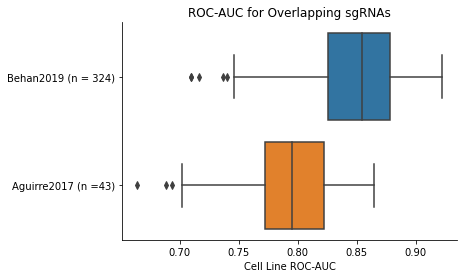

In [28]:
sns.boxplot(data=long_roc_aucs, y='dataset', x='ROC-AUC')
sns.despine()
plt.title('ROC-AUC for Overlapping sgRNAs')
plt.xlabel('Cell Line ROC-AUC')
plt.ylabel('')
gpplot.savefig('../figures/Behan_Aguirre_ROCAUC.png', dpi=300)